# Sensitivity analysis

Extensisq contains a couple functions to help with sensitivity analysis of an ODE solution to parameters (including initial values). This can be useful for finding periodic solutions, data fitting, or for solving boundary value problems using a shooting method. This notebook demonstrates the three types of sensitivity methods that are implemented: `sens_forward`, `sens_adjoint_end` and `sens_adjoint_int`.

Implementation of the sensitivity methods is based on the [CVODES paper](https://computing.llnl.gov/sites/default/files/toms_cvodes_with_covers.pdf). The extensisq methods can be used with any scipy or extensisq integration method, but does not have optimizations for any.

## Forward sensitivity analysis

The generalinitial value problem with parameters $\bm{p}$ is:
$$ \dot{\bm{y}} = \bm{f}(t, \bm{y}, \bm{p}), \qquad \bm{y}(t_0) = \bm{y}_0(\bm{p}) $$

The goal of forward sensitivity analysis is to find the matrix $\bm{S} = \frac{d \bm{y}}{d \bm{p}}$ over the integration interval, or just at the endpoint $t_f$.

The columns of $\bm{S}$ are $\bm{s}_i = \frac{d \bm{y}}{d p_i}$, one for each parameter. These columns are caculated from the initial value problem:
$$ \dot{\bm{s}}_i = \frac{\partial \bm{f}}{\partial \bm{y}} \bm{s}_i + \frac{\partial \bm{f}}{\partial p_i}, \qquad \bm{s}_i(t_0) = \frac{\partial \bm{y}_0(\bm{p})}{\partial p_i} $$
where $\frac{\partial \bm{f}}{\partial \bm{y}}$ is the (square) Jacobian matrix of the IVP of $\bm{y}$.

The function `sens_forward` the IVPs of $\bm{y}$ and all $\bm{s}_i$ together. The complete problem has size $N_y(1+N_p)$, which can be quite big. The function needs quite a few mandatory arguments:

In [1]:
from extensisq import sens_forward

help(sens_forward)

Help on function sens_forward in module extensisq.sensitivity:

sens_forward(fun, t_span, y0, jac, dfdp, dy0dp, p, atol=1e-06, rtol=0.001, method=<class 'extensisq.bogacki.BS5'>, dense_output=False, t_eval=None, use_approx_jac=False)
    Forward sensitivity analysis of an initial value problem.
    
    The method is called forward sensitivity analysis by [1]_ and internal
    differentiation by [2]_.
    
    The initial value problem is:
        dy = fun(t, y, p),    y(t0) = y0(p)
    
    And the result of interest is dy/dp over the integration interval and
    specifically at the endpoint (tf). The problem that is solved internally
    has size ny*(np+1).
    
    Parameters
    ----------
    fun : callable
        The function of the ODE that is solved with solve_ivp. The calling
        signature is fun(t, y, *p). It should return an array of length (ny,).
        (Same as for calling solve_ivp)
    t_span : 2-tuple of floats
        Interval of integration (t0, tf). The solver 

The arguments `fun`, `t_span`, `y0` and `jac` are known from `solve_ivp`. The main difference is that `jac` is mandatory for `sens_forward`. Important new arguments are `dfdp`, `dy0dp`, `p`, which can be recognized in the equations above.

I use the example from the book of [Hairer](https://doi.org/10.1007/978-3-540-78862-1) under "internal differentiation" to demonstrate `sens_forward`. It is the Brusselator problem, integrated from $t_0 = 0$ to $t_f = 20$. There is just one parameter: `B`. The required arguments are:

In [2]:
t_span = [0., 20.]
B = 3.08

def fun(x, y, B):
    y1, y2 = y
    f1 = 1 + y1**2 * y2 - (B + 1) * y1
    f2 = B * y1 - y1**2 * y2
    return [f1, f2]

y0 = [1.3, B]

def jac(x, y, B):
    y1, y2 = y
    df1dy1 = 2 * y1 * y2 - (B + 1)
    df1dy2 = y1**2
    df2dy1 = B - 2 * y1 * y2
    df2dy2 = -y1**2
    return [[df1dy1, df1dy2], [df2dy1, df2dy2]]

def dfdp(x, y, B):
    y1, y2 = y
    df1dB = -y1
    df2dB = y1
    return [[df1dB], [df2dB]]

dy0dp = [[0.], [1.]]

p = [B]

The sensitivity is now calculated  using `sens_forward`:

In [3]:

sens = sens_forward(fun, t_span, y0, jac, dfdp, dy0dp, p, rtol=1e-6)

print('solution y(tf)\n ', sens.yf)
print('sensitivity S(tf)\n', sens.sensf)


solution y(tf)
  [0.43879864 4.59277326]
sensitivity S(tf)
 [[-0.54419248]
 [-0.01428222]]


The printed output is the solution and sensitiity at the output point. The output tuple also contains the OdeResult object of the integration (in `sens.sol`). We could take a look at how the results vary over time.

nr of function evaluations 995


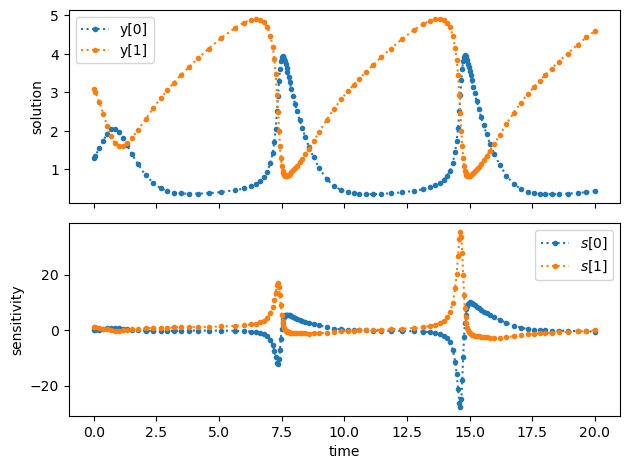

In [4]:
sol = sens.sol
print('nr of function evaluations', sol.nfev)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, sharex=True)

axs[0].plot(sol.t, sol.y[:2, :].T, '.:')
axs[1].plot(sol.t, sol.y[2:, :].T, '.:')
axs[1].set_xlabel('time')
axs[0].set_ylabel('solution')
axs[1].set_ylabel('sensitivity')
axs[0].legend(['y[0]', 'y[1]'])
axs[1].legend([r'$s[0]$', 
               r'$s[1]$'])
plt.tight_layout()
plt.show()

Notice how y and s are concatenated in the solution output. Neither the solution nor the sensitivity are smooth.

### Validation

Hairer shows a figure in his book with the sensitivities at tf of this problem for a few different values of B. This result can serve as a kind of validation of the `sensitivity` function. Let's try to reproduce it.

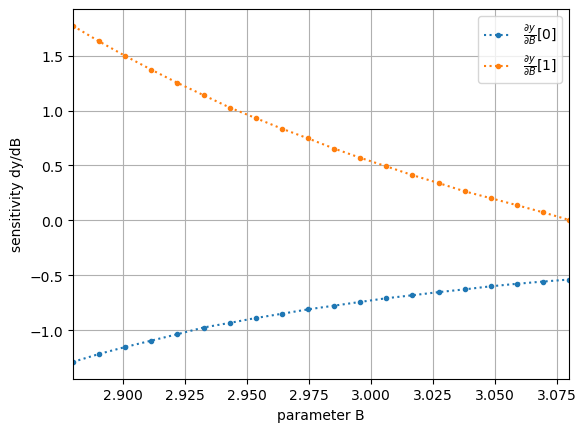

In [5]:
import numpy as np

results = []
Bs = np.linspace(2.88, 3.08, 20)
for B in Bs:
    y0 = [1.3, B]
    dy0dp = [[0.], [1.]]    # not dependent on B in this case
    _sens, _, _ = sens_forward(fun, t_span, y0, jac, dfdp, dy0dp, (B,))
    results.append(_sens.squeeze())

plt.plot(Bs, results, '.:')
plt.grid()
plt.xlim(Bs[0], Bs[-1])
plt.xlabel("parameter B")
plt.ylabel("sensitivity dy/dB")
plt.legend([r'$\frac{\partial y}{\partial B}[0]$', 
            r'$\frac{\partial y}{\partial B}[1]$'])
plt.show()

This figure resembles Hairer's figure quite well.

## Adjoint sensitivity, end point

Forward sensitivity analysis calculates the sensitivity to all solution components $y$. It becomes computationally costly if both the number of solution components and the number of paramters are large. If your are not intersted in the sensitivity of the solution, but rather a scalar value that is a function of the solution, then the adjoint sensitivity analysis can be much more efficient. So we have a scalar function of the solution:
$$g(t, \bm{y}, \bm{p})$$
Extensisq's function `sens_adjoint_end` can now calculate the sensitivity at the end point:
$$ \frac{d g}{d \bm{p}}(t_f) = \frac{\partial g}{\partial \bm{p}}(t_f) + \bm{\mu}^T (t_0) \bm{S}(t_0) + \int_{t_0}^{t_f} \bm{\mu}^T \frac{\partial \bm{f}}{\partial \bm{p}} dt $$

And $\bm{\mu}$ is calculated from the final value problem:
$$ \dot{\bm{\mu}} = - \left( \frac{\partial \bm{f}}{\partial {\bm{y}}} \right)^T \bm{\mu}, \qquad \bm{\mu}(t_f) = \left( \frac{\partial g}{\partial {\bm{y}}}(t_f) \right)^T $$

This adjoint sensitivity problem is solved in two steps. First the solution $\bm{y}$ is solved by a normal ODE integration, with dense output. Second, the solution $\bm{\mu}$ is solved by backward integration of the adjoint problem. The transpose of the jacobian can be evaluated, because the value of y is known from the first step. The definite integral in the sensitivity expressure can be evaluated separately (if $\bm{\mu}$ is solved with dense output as well). However, instead this integral is solved by appending it to the backward integration in the second step.

In [6]:
from extensisq import sens_adjoint_end

help(sens_adjoint_end)

Help on function sens_adjoint_end in module extensisq.sensitivity:

sens_adjoint_end(fun, t_span, y0, jac, dfdp, dy0dp, p, g, dgdp, dgdy, method=<class 'extensisq.bogacki.BS5'>, rtol=0.001, atol=1e-06, atol_adj=1e-06, atol_quad=1e-06, sol_y=None)
    sensitivity for a scalar function of the solution using the adjoint
    method.
    
    Define a function involving time, the solution of the IVP and parameters p:
    g(t, y, p). `sens_adjoint_tf` calculates its sensitivity at the end of
    the integration interval: dg/dp(tf). See [1]_ for details
    
    Parameters
    ----------
    fun : callable
        The function of the ODE that is solved with solve_ivp. The calling
        signature is fun(t, y, *p). It should return an array of length (ny,).
        (Same as for calling solve_ivp)
    t_span : 2-tuple of floats
        Interval of integration (t0, tf). The solver starts with t=t0 and
        integrates until it reaches t=tf. (Same as for calling solve_ivp)
    y0 : array_like,

Most arguments are known from the forward sensitivity. New are `g`, `dgdp`, and `dgdy`, which are all related to the function $g(t, \bm{y}, \bm{p})$. Lets apply it to the Brusselator problem and simply set g = y[0].

In [7]:
def g(t, y, p):
    return [y[0]]

def dgdy(t, y, p):
    return np.array([1., 0])

def dgdp(t, y, p):
    return np.array([0.])

sens_ae = sens_adjoint_end(fun, t_span, y0, jac, dfdp, dy0dp, p, g, dgdp, dgdy)

print('sensitivity', sens_ae.sens)
print('gf', sens_ae.gf)

sensitivity [-0.54727095]
gf [0.43840571]


These results are close to those from the forward sensitivity analysis. This example is not a typical case for adjoint sensitivity analysis. It becomes more useful if the numner of components in y and/or p is large.

## Adjoint sensitivity, integral

The third and last method calculates the sensitivity of a scalar function that contains the integral:
$$ G(\bm{p}) = \int_{t_0}^{t_f} g(t, \bm{y}, \bm{p}) dt $$

Extensisq's function `sens_adjoint_int` can calculate the sensitivity:
$$ \frac{d G}{d \bm{p}} = \bm{\lambda}^T(t_0) \bm{S}(t_0) + \int_{t_0}^{t_f} \left( \frac{\partial g}{\partial \bm{p}} + \lambda^T \frac{\partial \bm{f}}{\partial \bm{p}} \right) dt $$

And $\lambda$ is calculated with the final value problem:
$$ \dot{\bm{\lambda}} = -\left(\frac{\partial \bm{f}}{\partial \bm{y}}\right)^T \lambda - \left(\frac{\partial g}{\partial \bm{y}}\right)^T, \qquad \bm{\lambda}(t_f) = \bm{0}  $$

As with the previous method, this sensitivity is calculated in two steps: a forward solve of $\bm{y}$, and a backward solve of $\bm{\lambda}$ and the definite integral.

The arguments of `sens_adjoint_int` are the same as for `sens_adjoint_end`, but the output contains G instead of gt:

In [8]:
from extensisq import sens_adjoint_int

help(sens_adjoint_int)

Help on function sens_adjoint_int in module extensisq.sensitivity:

sens_adjoint_int(fun, t_span, y0, jac, dfdp, dy0dp, p, g, dgdp, dgdy, method=<class 'extensisq.bogacki.BS5'>, rtol=0.001, atol=1e-06, atol_adj=1e-06, atol_quad=1e-06, sol_y=None)
    Calculate the sensitivity dG/dp, where G is the integral over t_span of
    a function g(t, y, p). See [1]_ for details
    
    Parameters
    ----------
    fun : callable
        The function of the ODE that is solved with solve_ivp. The calling
        signature is fun(t, y, *p). It should return an array of length (ny,).
        (Same as for calling solve_ivp)
    t_span : 2-tuple of floats
        Interval of integration (t0, tf). The solver starts with t=t0 and
        integrates until it reaches t=tf. (Same as for calling solve_ivp)
    y0 : array_like, shape (ny,)
        Initial state. (Same as for calling solve_ivp)
    jac : callable
        function with signature jac(t, y, *p) that returns the Jacobian
        dfun/dy as an a

We don't have anything to compare it to, but this is how it can be used:

In [9]:
sens_ai = sens_adjoint_int(fun, t_span, y0, jac, dfdp, dy0dp, p, g, dgdp, dgdy)

print('sensitivity', sens_ai.sens)
print('G', sens_ai.G)

sensitivity [1.95488956]
G 19.341294118161642


## Discussion

This notebook has shown the usage and mathematical background of the three functions of sensitivity analysis in Extensisq. The forward analysis is most suitable when the sensitivity to all solution components is needed and the number of parameters is not too large. Adjoint sensitivity analysis on the other hand, is suitable when the number of parameters is large, but only the sensitivity to one scalar function of the solution is needed.

## Appendix: CVODES user manual examples

For further validation, I try to reproduce two examples from CVODES' [user manual](https://computing.llnl.gov/sites/default/files/cvs_guide.pdf). This results in boring lists of numbers that can be compared.

### Forward sensitivity

Compare to section 8.1.

In [10]:
def fun(t, y, *p):
    y1, y2, y3 = y
    p1, p2, p3 = p
    return np.array([-p1*y1 + p2*y2*y3,
                      p1*y1 - p2*y2*y3 - p3*y2**2,
                                         p3*y2**2])

def jac(t, y, *p):
    y1, y2, y3 = y
    p1, p2, p3 = p
    return np.array([[-p1, p2*y3, p2*y2],
                     [p1, -p2*y3 - 2*p3*y2, -p2*y2],
                     [0., 2*p3*y2, 0.]])

def dfdp(t, y, *p):
    y1, y2, y3 = y
    p1, p2, p3 = p
    return np.array([[-y1, y2*y3, 0.],
                     [y1, -y2*y3, -y2**2],
                     [0., 0., y2**2]])

y0 = np.array([1., 0., 0.])
t_eval = 4 * 10. ** np.arange(-1, 11)
t_span = (0., t_eval[-1])

p = (0.04, 1e4, 3e7)
dy0dp = np.zeros([3, 3])

rtol = 1e-4
atol = np.array([1e-8, 1e-14, 1e-6])

sens, yf, sol = sens_forward(fun, t_span, y0, jac, dfdp, dy0dp, p=p,
                             method='BDF', rtol=rtol, atol=atol,
                             t_eval=t_eval, use_approx_jac=False)

print('nfev:', sol.nfev)
print('njev:', sol.njev)

for t, y in zip(sol.t, sol.y.T):
    print(f'\nT: {t:8.2e}')
    print(f'Solution:     \t{y[0]:>11.4e}\t{y[1]:>11.4e}\t{y[2]:>11.4e}')
    print(f'Sensitivity 1:\t{y[3]:>11.4e}\t{y[4]:>11.4e}\t{y[5]:>11.4e}')
    print(f'Sensitivity 2:\t{y[6]:>11.4e}\t{y[7]:>11.4e}\t{y[8]:>11.4e}')
    print(f'Sensitivity 3:\t{y[9]:>11.4e}\t{y[10]:>11.4e}\t{y[11]:>11.4e}')


nfev: 1306
njev: 29

T: 4.00e-01
Solution:     	 9.8517e-01	 3.3864e-05	 1.4794e-02
Sensitivity 1:	-3.5595e-01	 3.9025e-04	 3.5556e-01
Sensitivity 2:	 9.5416e-08	-2.1310e-10	-9.5203e-08
Sensitivity 3:	-1.5831e-11	-5.2900e-13	 1.6360e-11

T: 4.00e+00
Solution:     	 9.0552e-01	 2.2405e-05	 9.4460e-02
Sensitivity 1:	-1.8761e+00	 1.7921e-04	 1.8760e+00
Sensitivity 2:	 2.9612e-06	-5.8308e-10	-2.9606e-06
Sensitivity 3:	-4.9331e-10	-2.7625e-13	 4.9358e-10

T: 4.00e+01
Solution:     	 7.1582e-01	 9.1852e-06	 2.8417e-01
Sensitivity 1:	-4.2477e+00	 4.5906e-05	 4.2477e+00
Sensitivity 2:	 1.3731e-05	-2.3571e-10	-1.3731e-05
Sensitivity 3:	-2.2884e-09	-1.1380e-13	 2.2885e-09

T: 4.00e+02
Solution:     	 4.5051e-01	 3.2227e-06	 5.4949e-01
Sensitivity 1:	-5.9585e+00	 3.5407e-06	 5.9585e+00
Sensitivity 2:	 2.2739e-05	-2.2592e-11	-2.2739e-05
Sensitivity 3:	-3.7898e-09	-4.9947e-14	 3.7898e-09

T: 4.00e+03
Solution:     	 1.8321e-01	 8.9430e-07	 8.1679e-01
Sensitivity 1:	-4.7500e+00	-5.9926e-06	 4.7500e+

This problem can be solved with LSODA, BDF or Radau as solver. All methods work if `use_approx_jac == False` and only "LSODA" seems to work well if `use_approx_jac == True`.

### Adjoint sensitivity (integral)

Compare to section 9.1

In [11]:
def g(t, y, *p):
    y1, y2, y3 = y
    p1, p2, p3 = p
    return [y1 + p2*y2*y3]

def dgdy(t, y, *p):
    y1, y2, y3 = y
    p1, p2, p3 = p
    return np.array([1., p2*y3, p2*y2])

def dgdp(t, y, *p):
    y1, y2, y3 = y
    p1, p2, p3 = p
    return np.array([0., y2*y3, 0.])

t_span = (0., 4e7)
atol_lambda = 1e-5
atol_quad = 1e-6

sens, G, sol_y, sol_bw = sens_adjoint_int(
    fun, t_span, y0, jac, dfdp, dy0dp, p, g, dgdp, dgdy, method='BDF',
    atol=atol, rtol=rtol, atol_quad=atol_quad, atol_adj=atol_lambda)
lambda0 = sol_bw.y[:3, -1]
print(f'G:\t\t{G:>11.4e}')
print(f'sensitivity:\t{sens[0]:>11.4e}\t{sens[1]:>11.4e}\t{sens[2]:>11.4e}')
print(f'lambda0:\t{lambda0[0]:>11.4e}\t{lambda0[1]:>11.4e}\t{lambda0[2]:>11.4e}')

G:		 1.8194e+04
sensitivity:	-7.8275e+05	 3.1959e+00	-5.3264e-04
lambda0:	 3.4196e+04	 3.4157e+04	 3.4156e+04
